# Projet 5 : Segmentez des clients d'un site de e-commerce
Date début : 05/02/2025

# Importation des libraires utiles

In [6]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
%matplotlib inline

import seaborn as sns

import math

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm

import csv

from scipy import stats

import missingno as msno

In [7]:
import sqlite3

In [8]:
from sklearn import datasets
from sklearn.cluster import KMeans

In [9]:
from sklearn import metrics

# Importation et aperçu des données

In [10]:
data_folder = "D:/GoogleDrive/Mon Drive/formations/OpenClassrooms/P5/"
file_name = "olist.db"

In [11]:
con = sqlite3.connect(data_folder+file_name)

In [12]:
cur = con.cursor()

## Lecture des tables

In [13]:
cur.execute("SELECT * FROM orders")
orders_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
orders_df = orders_df.set_index('index')

In [14]:
cur.execute("SELECT * FROM customers")
customers_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
customers_df = customers_df.set_index('index')

In [15]:
cur.execute("SELECT * FROM geoloc")
geoloc_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
geoloc_df = geoloc_df.set_index('index')

In [16]:
cur.execute("SELECT * FROM order_items")
order_items_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
order_items_df = order_items_df.set_index('index')

In [17]:
cur.execute("SELECT * FROM order_pymts")
order_pymts_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
order_pymts_df = order_pymts_df.set_index('index')

In [18]:
cur.execute("SELECT * FROM order_reviews")
order_reviews_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
order_reviews_df = order_reviews_df.set_index('index')

In [19]:
cur.execute("SELECT * FROM products")
products_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
products_df = products_df.set_index('index')

In [20]:
cur.execute("SELECT * FROM sellers")
sellers_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
sellers_df = sellers_df.set_index('index')

In [21]:
cur.execute("SELECT * FROM translation")
translation_df = pd.DataFrame(data=cur.fetchall(), columns=np.array(cur.description)[:,0])
translation_df = translation_df.set_index('index')

## Aperçu des données

In [22]:
customers_df

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
index,,,,,
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE


In [23]:
order_items_df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
index,,,,,,,
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95


In [24]:
products_df

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
index,,,,,,,,,
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0


In [25]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
index,,,,,,,,
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00


In [26]:
order_pymts_df

,order_id,payment_sequential,payment_type,payment_installments,payment_value
index,,,,,
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77


In [27]:
order_reviews_df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
index,,,,,,,
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,None,None,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,None,None,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,None,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43


In [28]:
sellers_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state
index,,,,
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP


In [29]:
geoloc_df

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
index,,,,,
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


In [30]:
translation_df

,product_category_name,product_category_name_english
index,,
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
...,...,...
66,flores,flowers
67,artes_e_artesanato,arts_and_craftmanship
68,fraldas_higiene,diapers_and_hygiene


# RFM

## Création de la table de données gloable RFM

In [31]:
data_RFM = customers_df.merge(orders_df, 'outer', on = 'customer_id')

In [32]:
data_RFM = data_RFM.merge(order_items_df, 'outer', on = 'order_id')

In [33]:
data_RFM['order_purchase_timestamp'] = pd.to_datetime(data_RFM['order_purchase_timestamp'])

In [34]:
data_RFM = data_RFM.loc[~data_RFM['price'].isnull()]

In [35]:
data_RFM_grouped = data_RFM.groupby(by=['customer_unique_id'])

In [36]:
data_RFM_stats = pd.DataFrame()
data_RFM_stats['Monetary'] = data_RFM_grouped['price'].sum()
data_RFM_stats['LastDate'] = data_RFM_grouped['order_purchase_timestamp'].max()
data_RFM_stats['Frequency'] = data_RFM_grouped['order_id'].size()

In [37]:
data_RFM_stats['Recency'] = (data_RFM_stats['LastDate'].max() - data_RFM_stats['LastDate']).dt.days

## Autres 1

In [38]:
orders_customers = orders_df.merge(customers_df, 'outer', on = 'customer_id')

In [39]:
orders_customers.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [40]:
orders_customers_sorted = orders_customers.sort_values(by='order_purchase_timestamp')

In [41]:
customers_first = orders_customers_sorted.groupby('customer_unique_id').first()

In [42]:
customers_nb = orders_customers.groupby('customer_unique_id').size()

In [43]:
customers_nb.value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

In [44]:
customers_nb_df = pd.DataFrame(customers_nb, columns=['nb'])

In [45]:
customers_first = customers_first.merge(customers_nb_df, 'inner', left_index=True, right_index=True)

In [46]:
customers_first = customers_first.reset_index()

In [47]:
customers_first = customers_first.merge(order_reviews_df, 'inner', on='order_id')

In [48]:
order_items_group = order_items_df[['order_id','price']].groupby(by='order_id').sum()

In [49]:
customers_first = customers_first.merge(order_items_group, 'left', left_on='order_id', right_index=True)

In [50]:
customers_first = customers_first.loc[~customers_first['price'].isnull()]

In [51]:
customers_first = customers_first.merge(data_RFM_stats, 'left', left_on='customer_unique_id', right_index=True)

In [52]:
customers_first_features = customers_first[['order_purchase_timestamp', 'customer_state', 'nb', 'review_score', 'price', 'Monetary']]

In [53]:
customers_first_features.columns

Index(['order_purchase_timestamp', 'customer_state', 'nb', 'review_score',
       'price', 'Monetary'],
      dtype='object')

<Axes: >

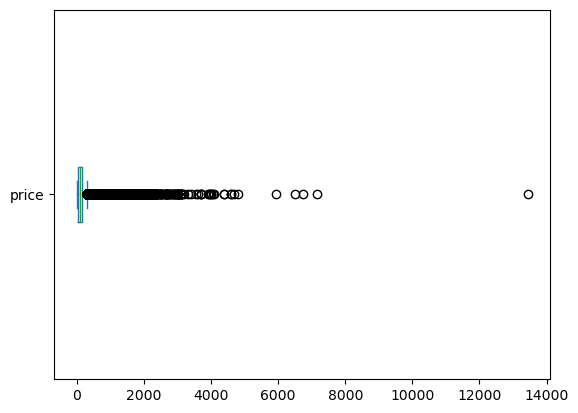

In [54]:
customers_first_features['price'].plot.box(vert=False)

In [55]:
customers_inliers = customers_first_features.loc[customers_first_features['price']<5000].copy()

In [56]:
customers_inliers_unique = customers_inliers.loc[customers_inliers['nb']==1].copy()
customers_inliers_multi = customers_inliers.loc[customers_inliers['nb']>1].copy()

In [57]:
customers_inliers['multi'] = customers_inliers['nb'] > 1

In [58]:
customers_first_features['nb'].value_counts()

nb
1     91825
2      2871
3       215
4        31
5        10
6         7
7         3
9         1
17        1
Name: count, dtype: int64

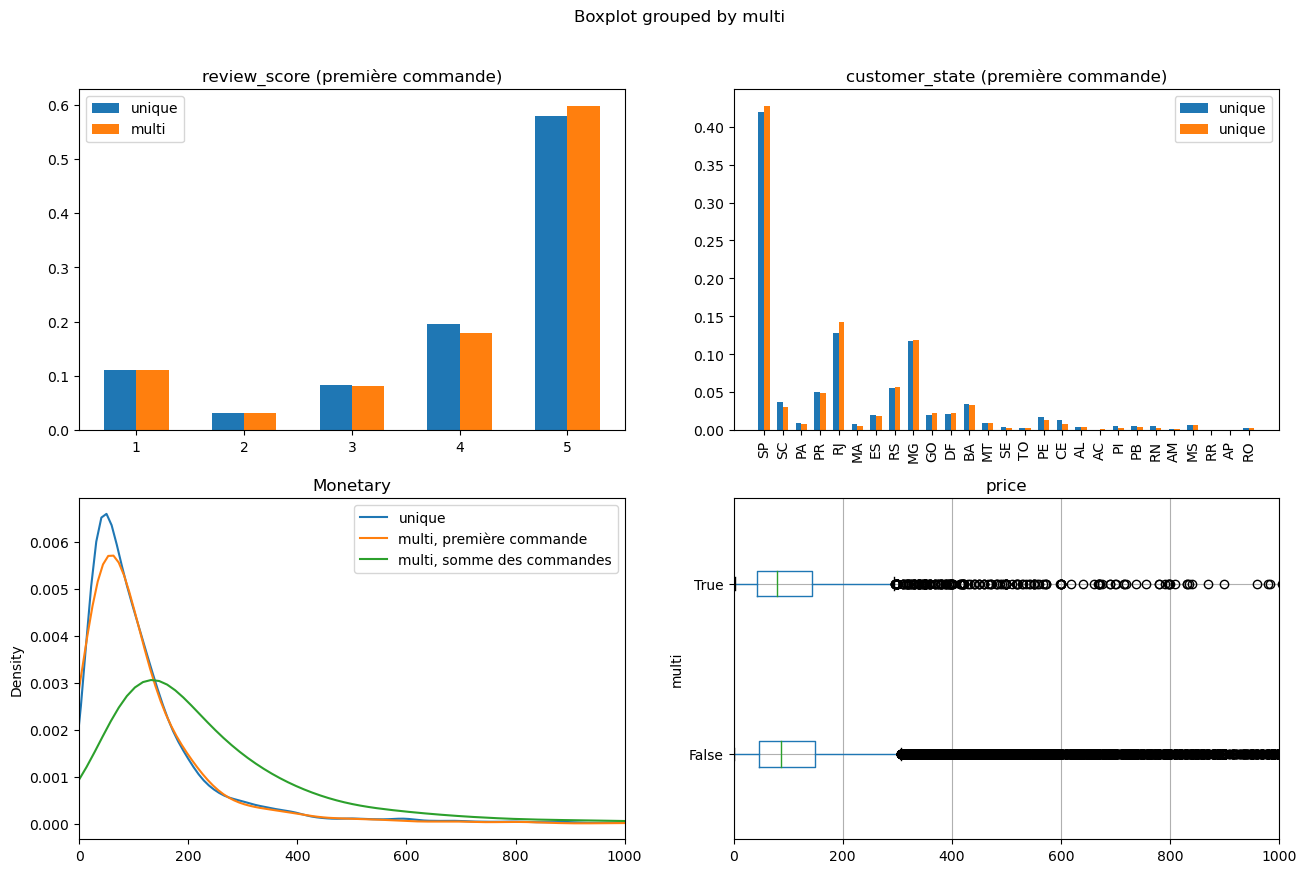

In [59]:
plt.figure(figsize=(15,10))

bar_width = 0.3

ax = plt.subplot(2,2,1)
ax.bar(np.arange(1,6)-bar_width/2,
       customers_inliers_unique['review_score'].value_counts(normalize=True).sort_index(),
       width=bar_width, label='unique')
ax.bar(np.arange(1,6)+bar_width/2,
       customers_inliers_multi['review_score'].value_counts(normalize=True).sort_index(),
       width=bar_width, label='multi')
ax.set_title('review_score (première commande)')
ax.legend()

ax = plt.subplot(2,2,2)
ax.bar(np.arange(len(customers_first_features['customer_state'].unique()))-bar_width/2,
       customers_inliers_unique['customer_state'].value_counts(normalize=True).reindex(
           customers_inliers['customer_state'].unique(), fill_value=0),
       width=bar_width, label='unique')
ax.bar(np.arange(len(customers_first_features['customer_state'].unique()))+bar_width/2,
       customers_inliers_multi['customer_state'].value_counts(normalize=True).reindex(
           customers_inliers['customer_state'].unique(), fill_value=0),
       width=bar_width, label='unique')
ax.set_xticks(np.arange(len(customers_inliers['customer_state'].unique())), customers_inliers['customer_state'].unique(), rotation=90)
ax.set_title('customer_state (première commande)')
ax.legend()

ax = plt.subplot(2,2,3)
customers_inliers_unique['price'].plot.density(ax=ax, label='unique')
customers_inliers_multi['price'].plot.density(ax=ax, label='multi, première commande')
customers_inliers_multi['Monetary'].plot.density(ax=ax, label='multi, somme des commandes')
ax.set_xlim([0, 1000])
ax.set_title('Monetary')
ax.legend()

ax = plt.subplot(2,2,4)
customers_inliers.boxplot(ax=ax, column='price', by='multi', vert=False)
ax.set_xlim([0, 1000])

plt.show()

In [60]:
customers_inliers['order_purchase_timestamp'] = pd.to_datetime(customers_inliers['order_purchase_timestamp'])
customers_inliers['Recency'] = (customers_inliers['order_purchase_timestamp'].max() - customers_inliers['order_purchase_timestamp']).dt.days

In [61]:
states_others = np.sort(customers_inliers['customer_state'].unique())[
customers_inliers['customer_state'].value_counts(normalize=True).sort_index() < 0.01]

In [62]:
customers_inliers.loc[customers_inliers['customer_state'].isin(states_others), 'customer_state'] = 'Other'

In [63]:
customers_inliers['customer_state'].value_counts(normalize=True)

customer_state
SP       0.419191
RJ       0.128319
MG       0.117303
Other    0.065544
RS       0.055234
PR       0.050780
SC       0.036700
BA       0.034036
DF       0.021694
GO       0.020398
ES       0.020388
PE       0.016776
CE       0.013637
Name: proportion, dtype: float64

In [64]:
X = customers_inliers.reset_index().copy()

In [65]:
X.drop('order_purchase_timestamp', inplace=True, axis=1)
X.drop('index', inplace=True, axis=1)

In [66]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
X_labeled = pd.DataFrame(data=label_binarizer.fit_transform(X['customer_state']), columns=label_binarizer.classes_)

In [67]:
X = pd.concat([X, X_labeled], axis=1)
X.drop('customer_state', inplace=True, axis=1)

In [68]:
X.shape

(94959, 19)

In [69]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [65]:
n_components = 15

In [66]:
pca = PCA(n_components=n_components)
pca.fit(X_std)

PCA(n_components=15)

In [67]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)

In [68]:
X_std = pd.DataFrame(data=X_std, columns=X.columns)

Text(0.5, 1.0, 'Eboulis des valeurs propres')

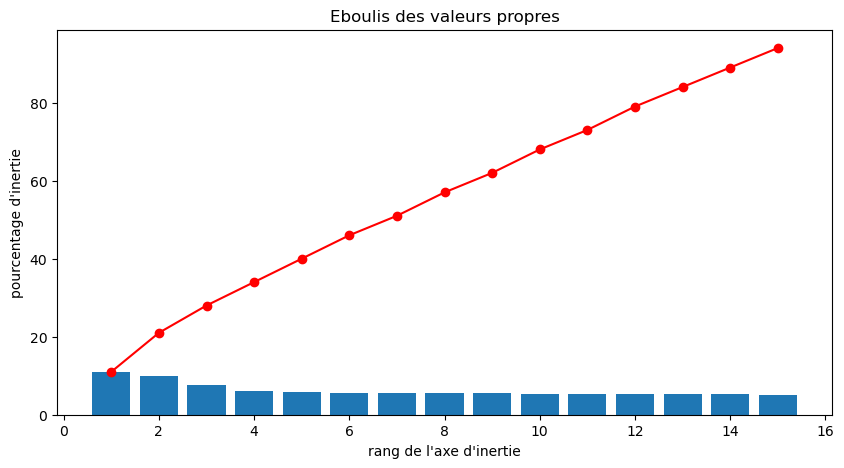

In [69]:
fig = plt.figure(figsize=(10,5))
ax=plt.subplot(1,1,1)
ax.bar(x_list, scree)
ax.plot(x_list, scree_cum,c="red",marker='o')
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("pourcentage d'inertie")
ax.set_title("Eboulis des valeurs propres")

In [70]:
def correlation_graph(pca, 
                      x_y, 
                      features, ax) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    #fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        ax.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    ax.plot([-1, 1], [0, 0], color='grey', ls='--')
    ax.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    ax.set_ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    ax.set_title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    #plt.show(block=False)

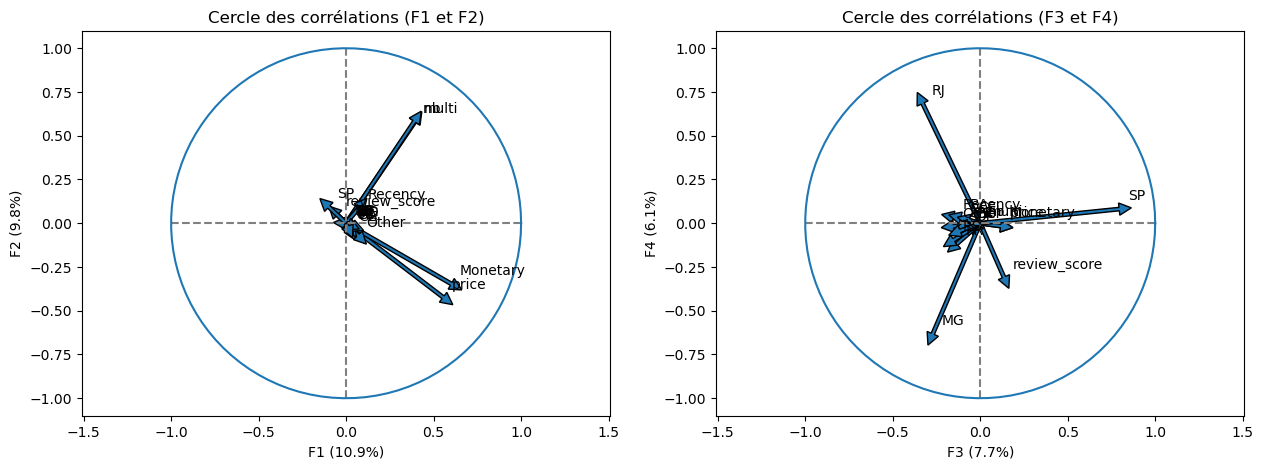

In [71]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
correlation_graph(pca, (0,1), X.columns, ax)

ax=plt.subplot(1,2,2)
correlation_graph(pca, (2,3), X.columns, ax)

In [72]:
X_std_red = X_std[['Monetary', 'nb', 'SP', 'Recency','review_score']].copy()

In [73]:
n_components = 5

In [74]:
pca = PCA(n_components=n_components)
pca.fit(X_std_red)

PCA(n_components=5)

In [75]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)

Text(0.5, 1.0, 'Eboulis des valeurs propres')

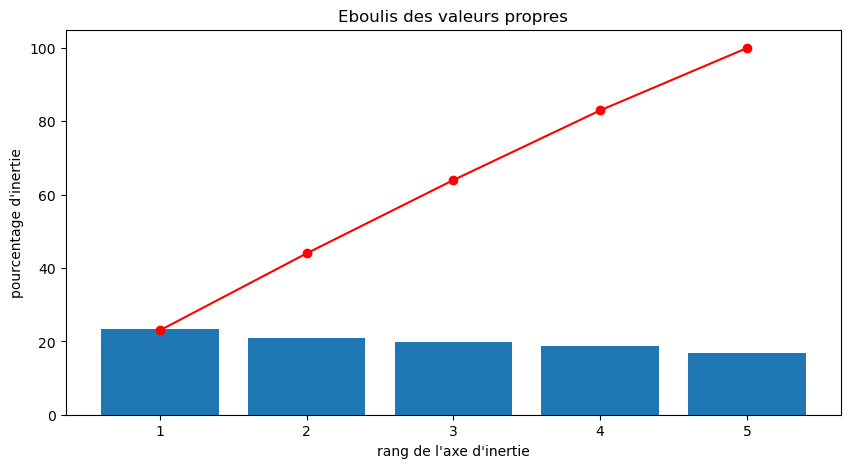

In [76]:
fig = plt.figure(figsize=(10,5))
ax=plt.subplot(1,1,1)
ax.bar(x_list, scree)
ax.plot(x_list, scree_cum,c="red",marker='o')
ax.set_xlabel("rang de l'axe d'inertie")
ax.set_ylabel("pourcentage d'inertie")
ax.set_title("Eboulis des valeurs propres")

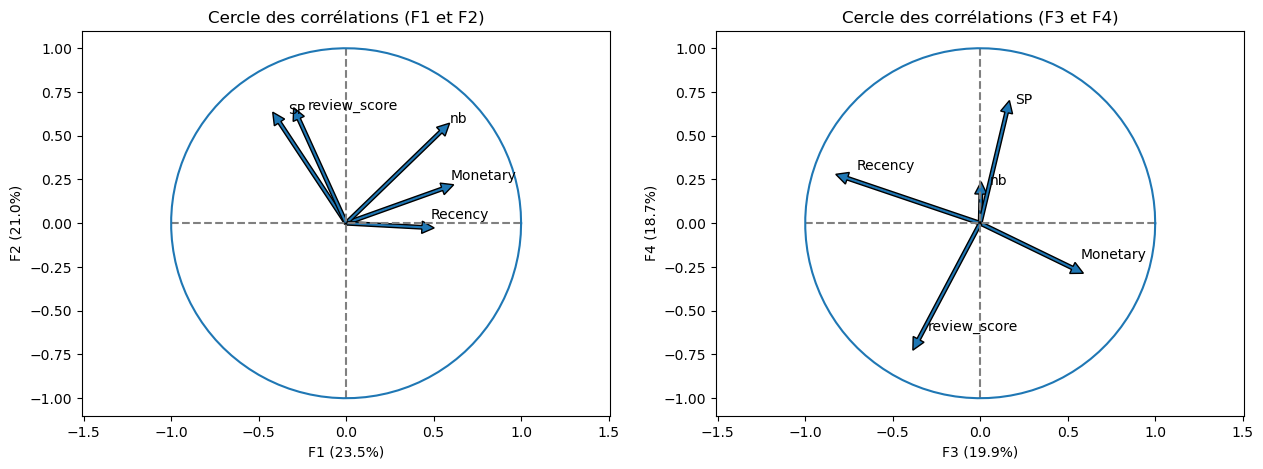

In [77]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
correlation_graph(pca, (0,1), X_std_red.columns, ax)

ax=plt.subplot(1,2,2)
correlation_graph(pca, (2,3), X_std_red.columns, ax)

In [78]:
X_red_proj = pca.transform(X_std_red)
X_red_proj = pd.DataFrame(data=X_red_proj)

In [79]:
intertia = []
silhouettes = []

In [80]:
k_list = range(2, 10)

In [81]:
for i in k_list :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_std_red) 
    intertia.append(kmeans.inertia_)
    silh = metrics.silhouette_score(X_std_red, kmeans.labels_)
    silhouettes.append(silh)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

Text(0.5, 1.0, 'X_std_red')

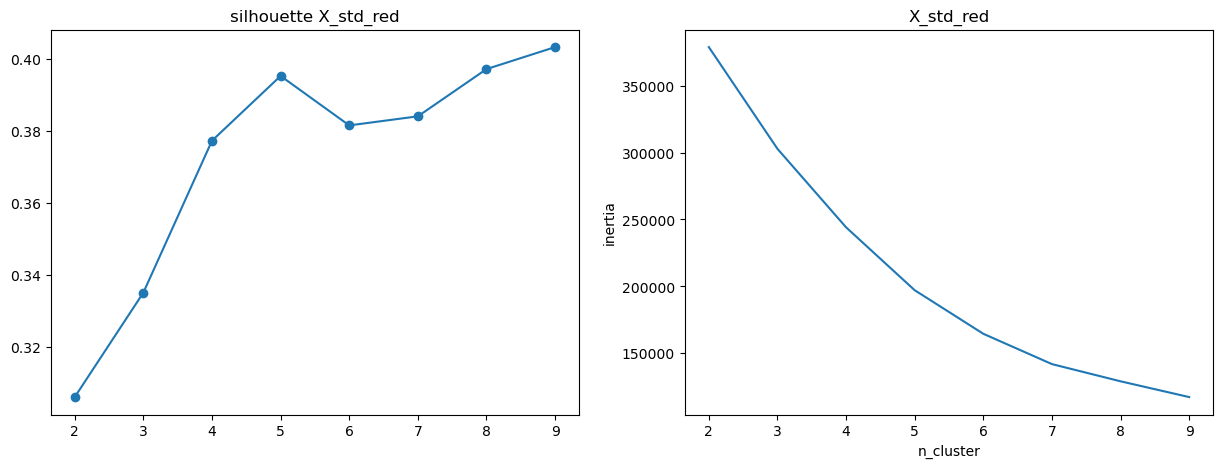

In [82]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.plot(range(2,10), silhouettes, marker='o')
ax.set_title('silhouette X_std_red')

ax=plt.subplot(1,2,2)
ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
ax.plot(k_list, intertia)
ax.set_title('X_std_red')

In [83]:
n_clusters=5

In [84]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_std_red)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

In [85]:
X_std_red["cluster"] = kmeans.labels_
X_red_proj["cluster"] = kmeans.labels_

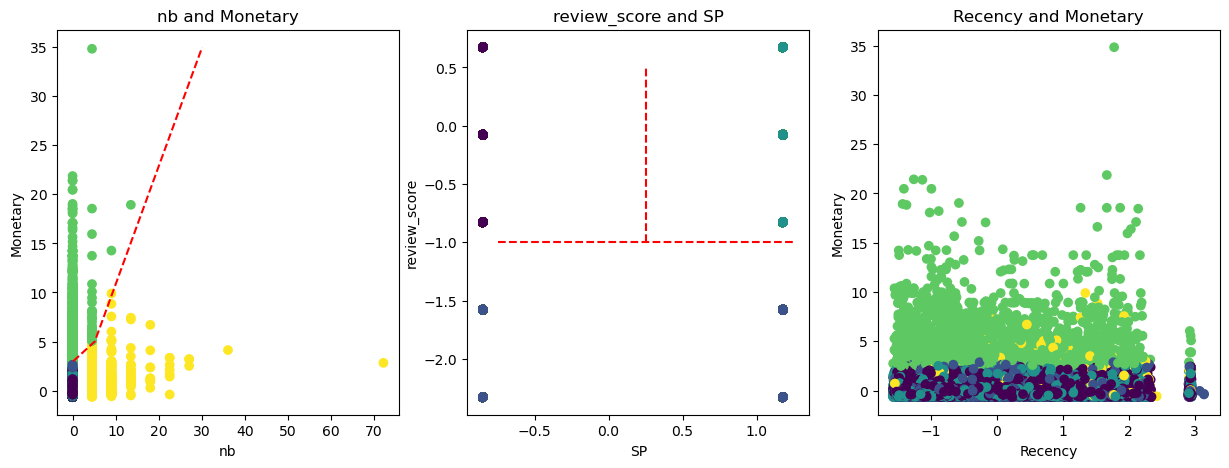

In [86]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
ax.scatter(X_std_red["nb"], X_std_red["Monetary"], c=X_std_red["cluster"])
ax.plot([0, 5, 30], [3, 5, 35], '--r')
ax.set_xlabel('nb')
ax.set_ylabel('Monetary')
ax.set_title('nb and Monetary')

ax=plt.subplot(1,3,2)
ax.scatter(X_std_red["SP"], X_std_red["review_score"], c=X_std_red["cluster"])
ax.plot([-0.75, 1.25], [-1, -1], '--r')
ax.plot([0.25, 0.25], [-1, 0.5], '--r')
ax.set_title('review_score and SP')
ax.set_xlabel('SP')
ax.set_ylabel('review_score')

ax=plt.subplot(1,3,3)
ax.scatter(X_std_red["Recency"], X_std_red["Monetary"], c=X_std_red["cluster"])
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('Recency and Monetary')

plt.show()

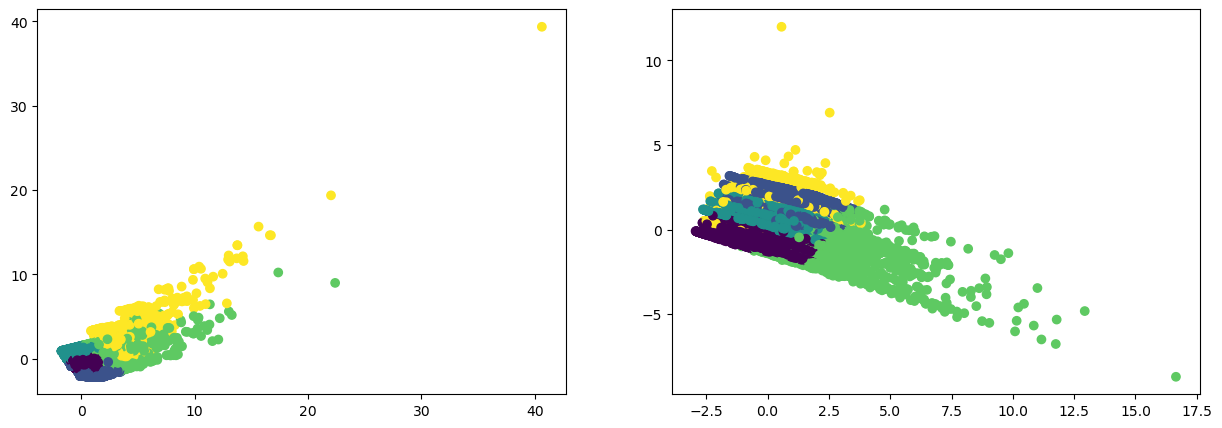

In [87]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.scatter(X_red_proj[0], X_red_proj[1], c=X_red_proj["cluster"])

ax=plt.subplot(1,2,2)
ax.scatter(X_red_proj[2], X_red_proj[3], c=X_red_proj["cluster"])

plt.show()

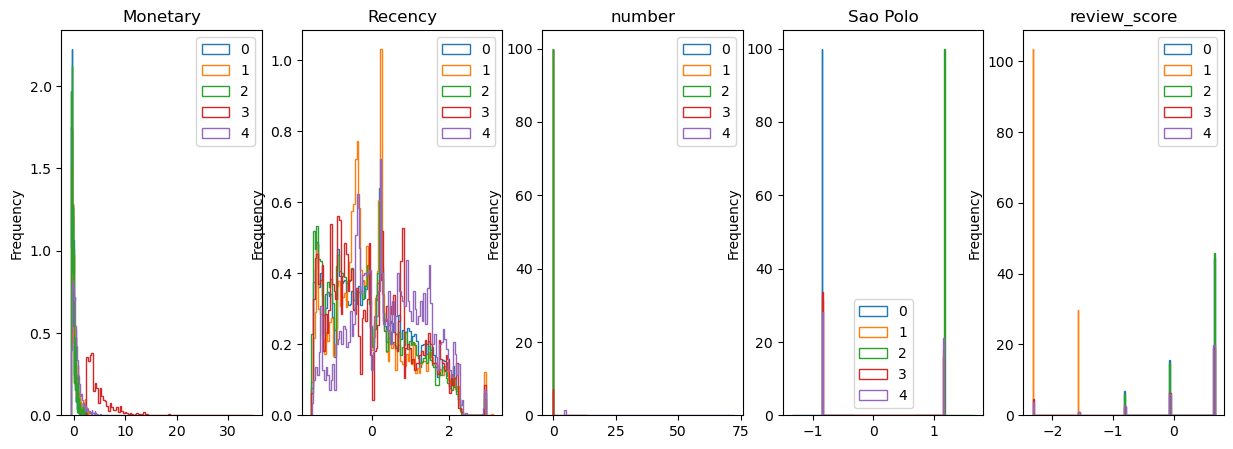

In [88]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,5,1)
for i in range(n_clusters):
    X_std_red.loc[X_std_red['cluster']==i, "Monetary"].plot.hist(density=True, histtype='step', bins=100, label=i)
ax.legend()
ax.set_title('Monetary')

ax=plt.subplot(1,5,2)
for i in range(n_clusters):
    X_std_red.loc[X_std_red['cluster']==i, "Recency"].plot.hist(density=True, histtype='step', bins=100, label=i)
ax.legend()
ax.set_title('Recency')

ax=plt.subplot(1,5,3)
for i in range(n_clusters):
    X_std_red.loc[X_std_red['cluster']==i, "nb"].plot.hist(density=True, histtype='step', bins=100, label=i)
ax.legend()
ax.set_title('number')

ax=plt.subplot(1,5,4)
for i in range(n_clusters):
    X_std_red.loc[X_std_red['cluster']==i, "SP"].plot.hist(density=True, histtype='step', bins=100, label=i)
ax.legend()
ax.set_title('Sao Polo')

ax=plt.subplot(1,5,5)
for i in range(n_clusters):
    X_std_red.loc[X_std_red['cluster']==i, "review_score"].plot.hist(density=True, histtype='step', bins=100, label=i)
ax.legend()
ax.set_title('review_score')

plt.show()

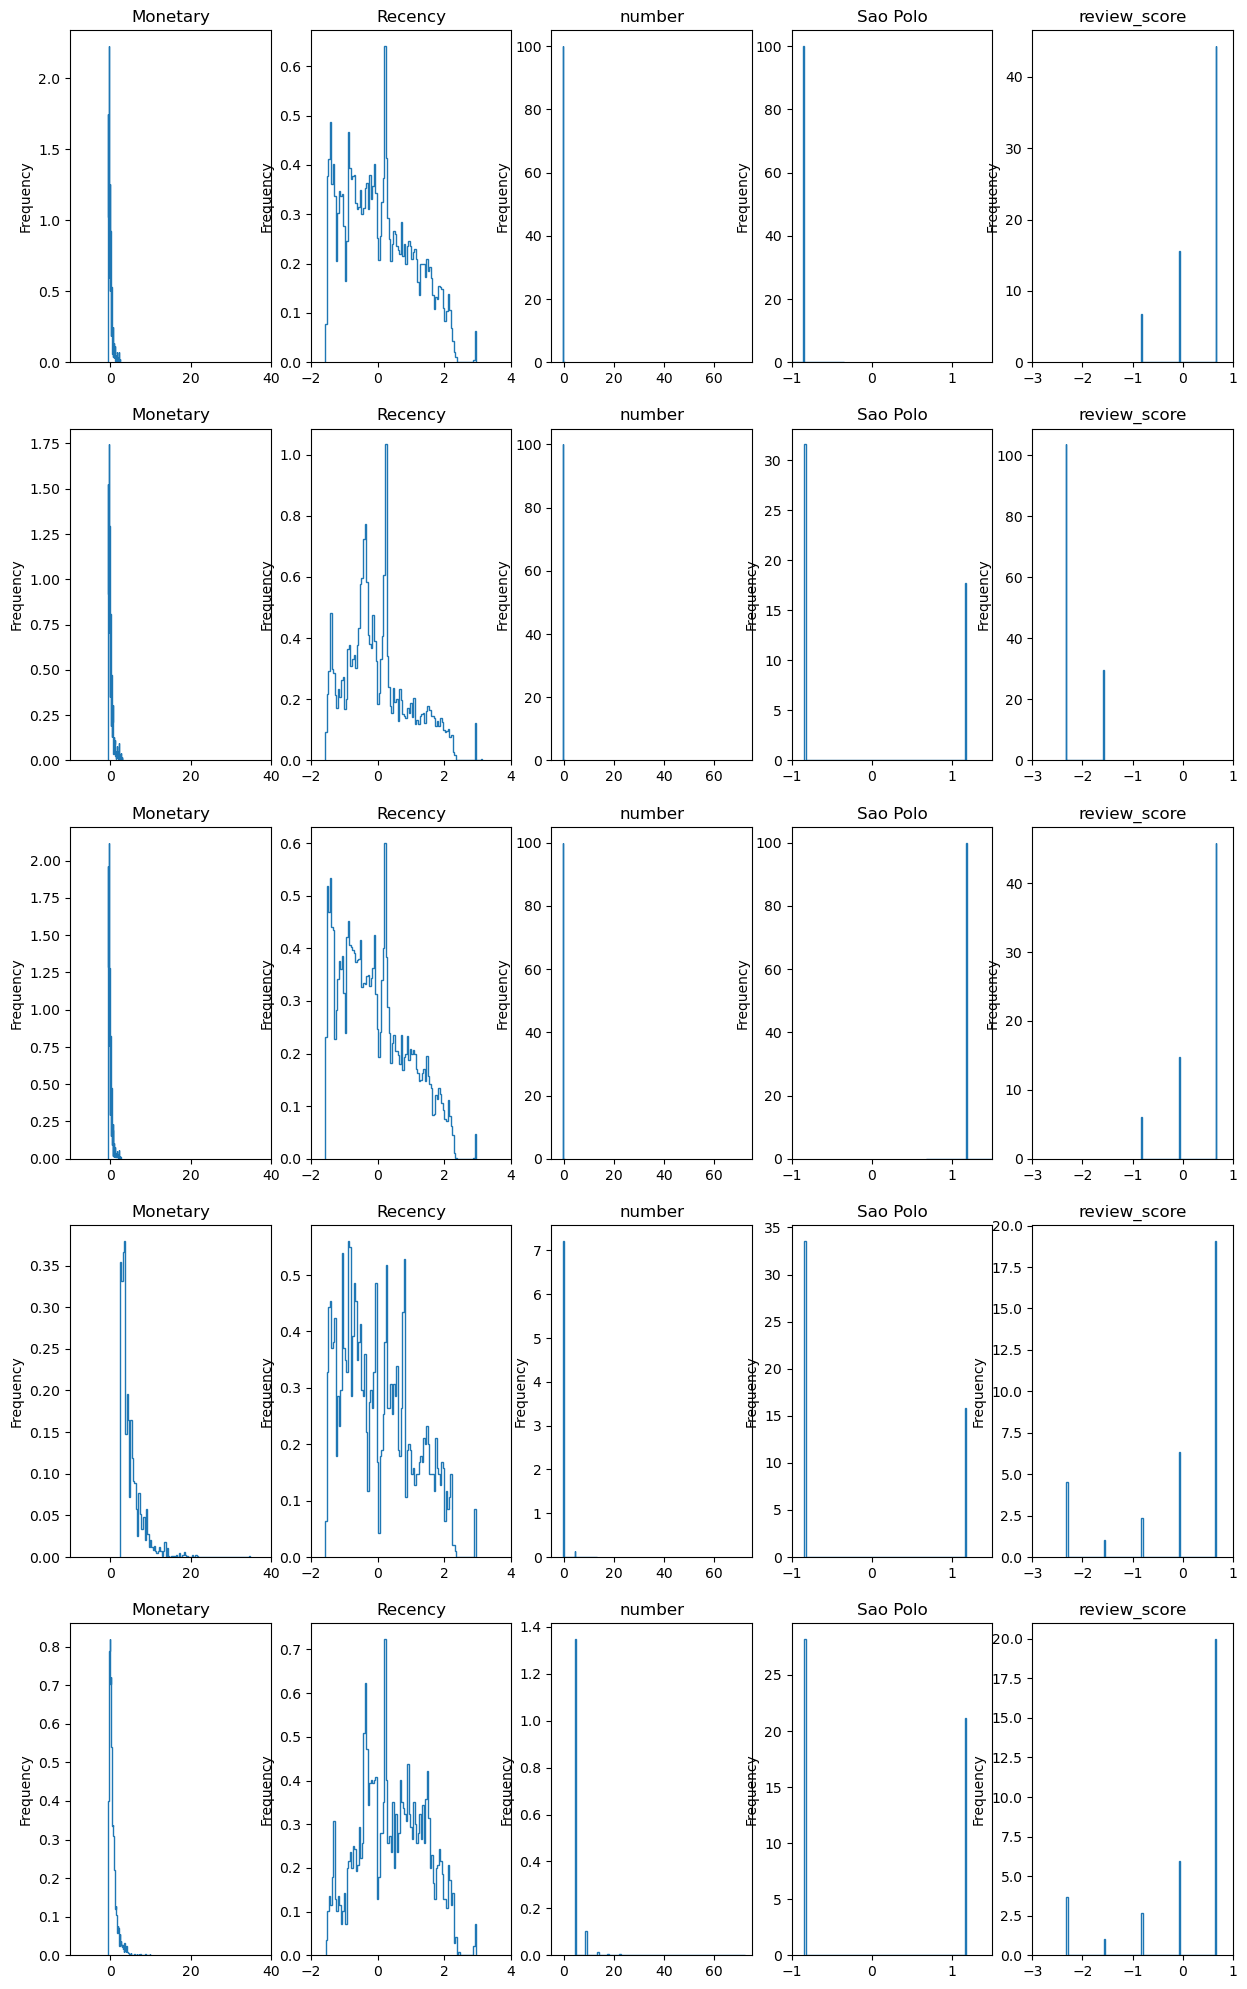

In [89]:
fig = plt.figure(figsize=(15,25))

for i in range(n_clusters):
    ax=plt.subplot(5,5,5*i+1)
    X_std_red.loc[X_std_red['cluster']==i, "Monetary"].plot.hist(density=True, histtype='step', bins=100, label=i)
    ax.set_title('Monetary')
    ax.set_xlim([-10, 40])

    ax=plt.subplot(5,5,5*i+2)
    X_std_red.loc[X_std_red['cluster']==i, "Recency"].plot.hist(density=True, histtype='step', bins=100, label=i)
    ax.set_title('Recency')
    ax.set_xlim([-2, 4])

    ax=plt.subplot(5,5,5*i+3)
    X_std_red.loc[X_std_red['cluster']==i, "nb"].plot.hist(density=True, histtype='step', bins=100, label=i)
    ax.set_title('number')
    ax.set_xlim([-5, 75])

    ax=plt.subplot(5,5,5*i+4)
    X_std_red.loc[X_std_red['cluster']==i, "SP"].plot.hist(density=True, histtype='step', bins=100, label=i)
    ax.set_title('Sao Polo')
    ax.set_xlim([-1, 1.5])

    ax=plt.subplot(5,5,5*i+5)
    X_std_red.loc[X_std_red['cluster']==i, "review_score"].plot.hist(density=True, histtype='step', bins=100, label=i)
    ax.set_title('review_score')
    ax.set_xlim([-3, 1])

plt.show()

## Classification des données

In [90]:
R_bins = [0, 90, 180, 365, 650, data_RFM_stats['Recency'].max()]
F_bins = [0, 1, data_RFM_stats['Frequency'].max()]
M_bins = [0, 50, 150, 300, 1000, data_RFM_stats['Monetary'].max()]

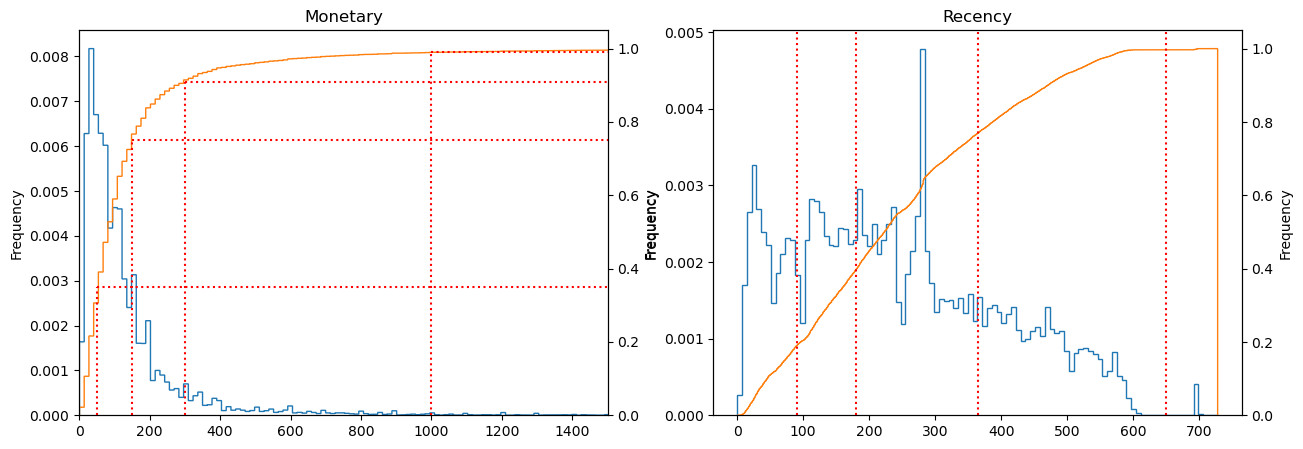

In [91]:
x_max = 1500
f_cum = [0.35, 0.75, 0.91, 0.99]

plt.figure(figsize=(15,5))

ax = plt.subplot(1,2,1)
data_RFM_stats['Monetary'].plot.hist(ax=ax, bins=1000, density = True, histtype='step')
ax = ax.twinx()
data_RFM_stats['Monetary'].plot.hist(ax=ax, bins=1000, density=True, cumulative=True, histtype='step', color='tab:orange')

for i in range(4):
    ax.plot([M_bins[i+1], x_max], [f_cum[i], f_cum[i]], ':r')
    ax.plot([M_bins[i+1], M_bins[i+1]], [0, f_cum[i]], ':r')

ax.set_title('Monetary')
plt.xlim([0,x_max])

ax = plt.subplot(1,2,2)
data_RFM_stats['Recency'].plot.hist(ax=ax, bins=100, density = True, histtype='step')
ax = ax.twinx()
data_RFM_stats['Recency'].plot.hist(ax=ax, bins=1000, density=True, cumulative=True, histtype='step', color='tab:orange')

for i in range(4):
    ax.axvline(R_bins[i+1], linestyle=':', color='r')

ax.set_title('Recency')
plt.show()

In [92]:
data_RFM_stats['R'] = pd.cut(data_RFM_stats['Recency'], bins=R_bins, labels = range(1, 6), include_lowest=True).astype(str)
data_RFM_stats['M'] = pd.cut(data_RFM_stats['Monetary'], bins=M_bins, labels = range(1, 6), include_lowest=True).astype(str)
data_RFM_stats['F'] = pd.cut(data_RFM_stats['Frequency'], bins=F_bins, labels = range(1, 3), include_lowest=True).astype(str)

In [93]:
data_RFM_stats['RFM'] = data_RFM_stats['R'] + data_RFM_stats['F'] + data_RFM_stats['M']

In [94]:
data_RFM_stats_grouped = data_RFM_stats.groupby(by='RFM')

In [95]:
data_RFM_stats_density = pd.DataFrame()
data_RFM_stats_density['R'] = data_RFM_stats_grouped['R'].first()
data_RFM_stats_density['F'] = data_RFM_stats_grouped['F'].first()
data_RFM_stats_density['M'] = data_RFM_stats_grouped['M'].first()
data_RFM_stats_density['d'] = data_RFM_stats_grouped['R'].size()

## Représentation RFM

In [96]:
len(data_RFM_stats.loc[data_RFM_stats['Frequency']==1])/len(data_RFM_stats)*100

87.56130790190736

In [97]:
len(data_RFM_stats.loc[data_RFM_stats['Frequency']>1])/len(data_RFM_stats)*100

12.438692098092643

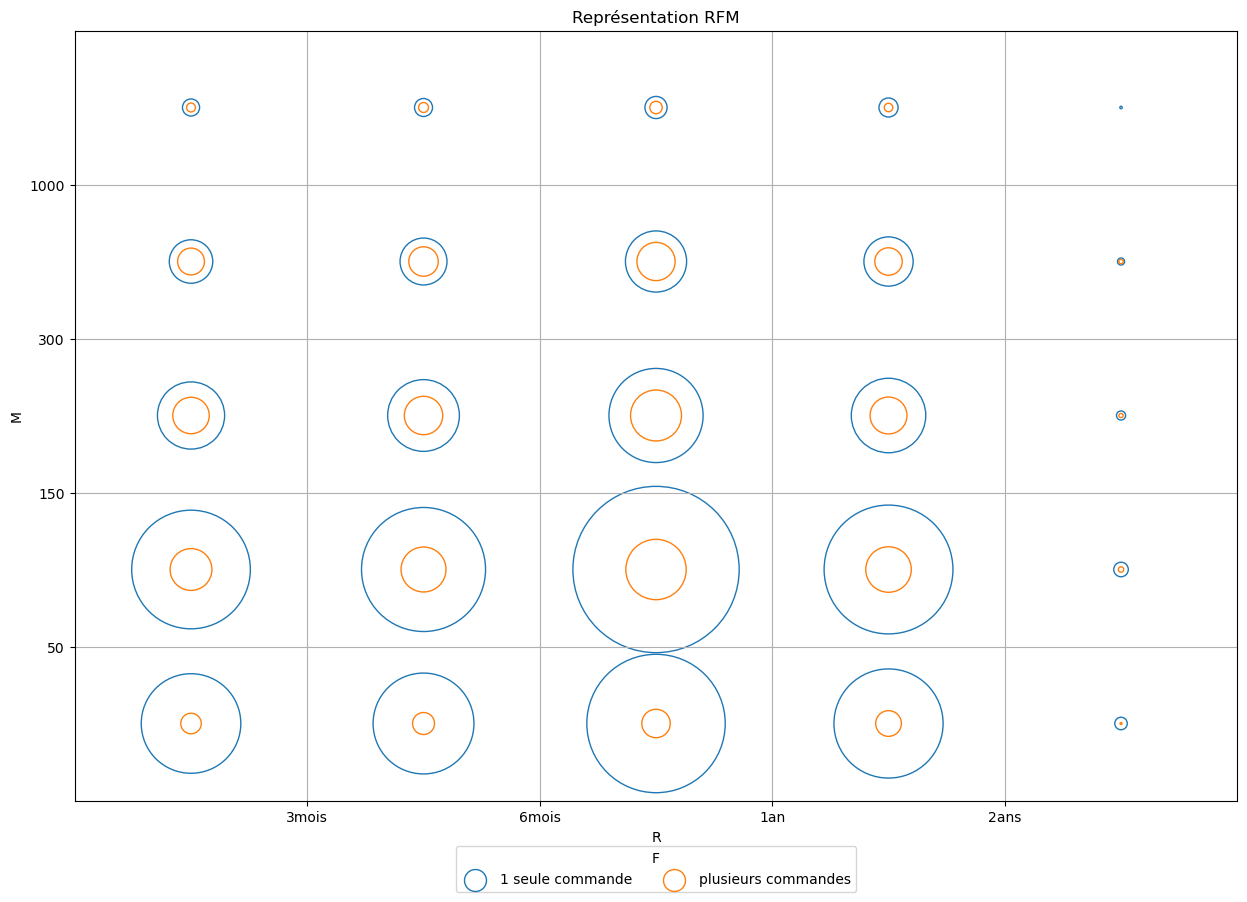

In [98]:
plt.figure(figsize=(15,10))

ax = plt.subplot(1,1,1)
data_RFM_stats_density.loc[data_RFM_stats_density['F']=='1'].plot.scatter(ax=ax, x='R', y='M', s='d', label='1 seule commande',
                                                                          marker='o', edgecolors='tab:blue', color='w')
data_RFM_stats_density.loc[data_RFM_stats_density['F']=='2'].plot.scatter(ax=ax, x='R', y='M', s='d', label='plusieurs commandes',
                                                                          marker='o', edgecolors='tab:orange', color='w')

ax.set_xticks([0.5, 1.5, 2.5, 3.5], ['3mois', '6mois', '1an', '2ans'])
ax.set_yticks([0.5, 1.5, 2.5, 3.5], M_bins[1:-1])
plt.xlim([-0.5, 4.5])
plt.ylim([-0.5, 4.5])
plt.grid()
lgnd = plt.legend(title='F', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
lgnd.legend_handles[1].set_sizes([250])
lgnd.legend_handles[0].set_sizes([250])

plt.title('Représentation RFM')

plt.show()

In [70]:
X = data_RFM_stats[['Recency', 'Monetary', 'Frequency']].copy()

In [100]:
intertia = []
silhouettes = []

In [101]:
k_list = range(2, 10)

In [102]:
for i in k_list :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X) 
    intertia.append(kmeans.inertia_)
    silh = metrics.silhouette_score(X, kmeans.labels_)
    silhouettes.append(silh)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

Text(0.5, 1.0, 'X')

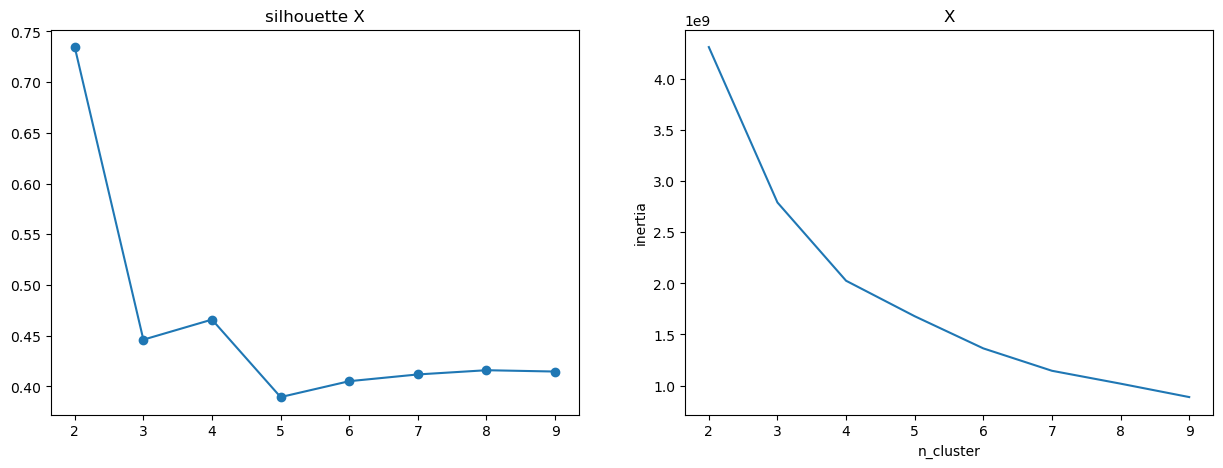

In [103]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.plot(range(2,10), silhouettes, marker='o')
ax.set_title('silhouette X')

ax=plt.subplot(1,2,2)
ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
ax.plot(k_list, intertia)
ax.set_title('X')

In [104]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [105]:
X["cluster"] = kmeans.labels_

D:\logiciels\Python\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


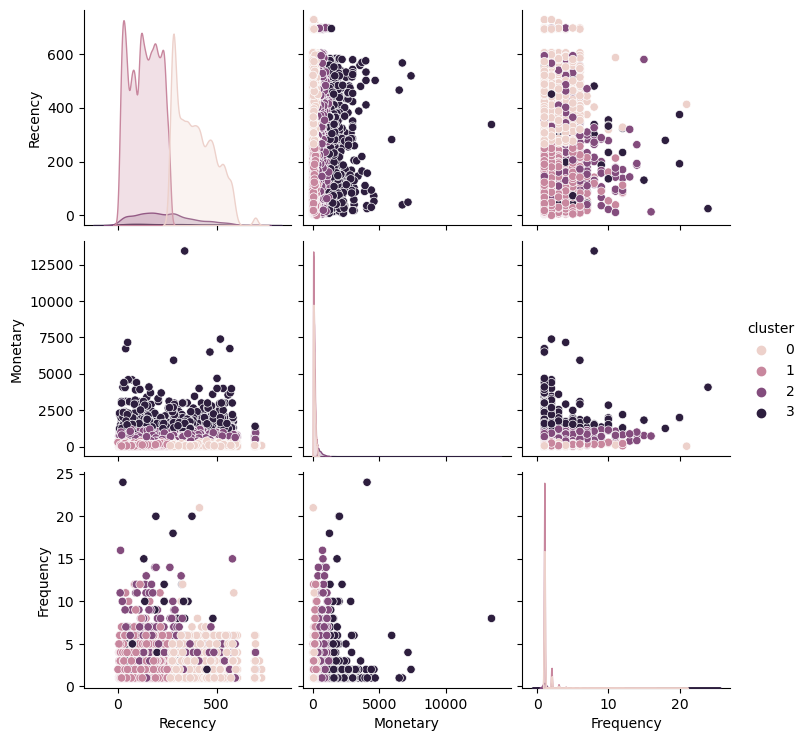

In [106]:
sns.pairplot(X, hue="cluster")

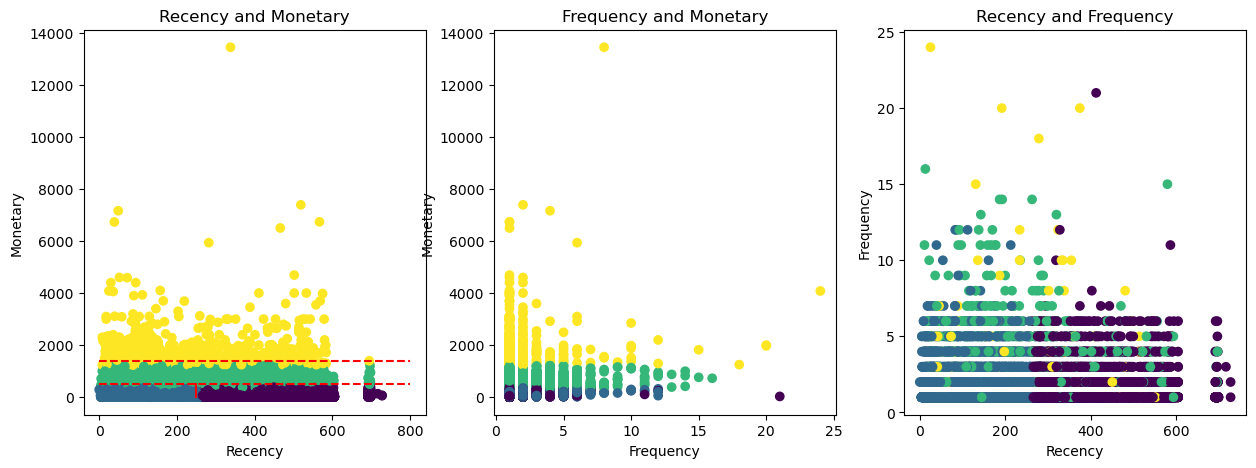

In [107]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
ax.scatter(X["Recency"], X["Monetary"], c=X["cluster"])
ax.plot([0, 800], [1400, 1400], '--r')
ax.plot([0, 800], [500, 500], '--r')
ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('Recency and Monetary')

ax=plt.subplot(1,3,2)
ax.scatter(X["Frequency"], X["Monetary"], c=X["cluster"])
#ax.plot([-0.75, 1.25], [-1, -1], '--r')
#ax.plot([0.25, 0.25], [-1, 0.5], '--r')
ax.set_title('Frequency and Monetary')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax=plt.subplot(1,3,3)
ax.scatter(X["Recency"], X["Frequency"], c=X["cluster"])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_title('Recency and Frequency')

plt.show()

In [108]:
silhouette_avg = metrics.silhouette_score(X=X[['Recency', 'Monetary', 'Frequency']], labels=X["cluster"])

In [109]:
sample_silhouette_values = metrics.silhouette_samples(X=X[['Recency', 'Monetary', 'Frequency']], labels=X["cluster"])

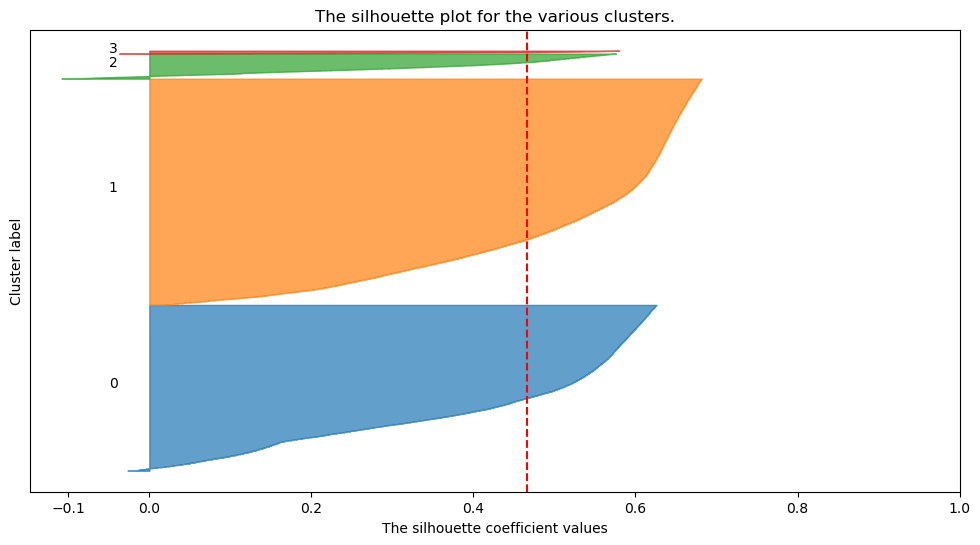

In [110]:
fig, ax1 = plt.subplots(1,1,figsize=(12,6))

n_clusters = 4

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[X["cluster"] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = list(colors.TABLEAU_COLORS.values())[i]
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

In [71]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [112]:
intertia = []
silhouettes = []

In [113]:
k_list = range(2, 10)

In [114]:
for i in k_list :
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X_std) 
    intertia.append(kmeans.inertia_)
    silh = metrics.silhouette_score(X, kmeans.labels_)
    silhouettes.append(silh)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

Text(0.5, 1.0, 'X_std')

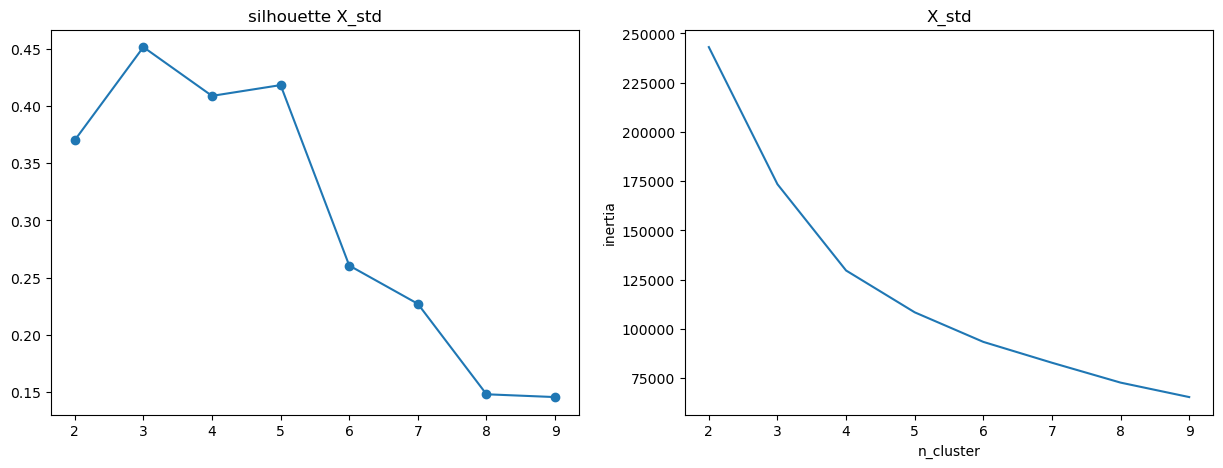

In [115]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.plot(range(2,10), silhouettes, marker='o')
ax.set_title('silhouette X_std')

ax=plt.subplot(1,2,2)
ax.set_ylabel("inertia")
ax.set_xlabel("n_cluster")
ax.plot(k_list, intertia)
ax.set_title('X_std')

In [116]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_std)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [73]:
X_std = pd.DataFrame(data=X_std, columns=X.columns)

In [118]:
X_std["cluster"] = kmeans.labels_

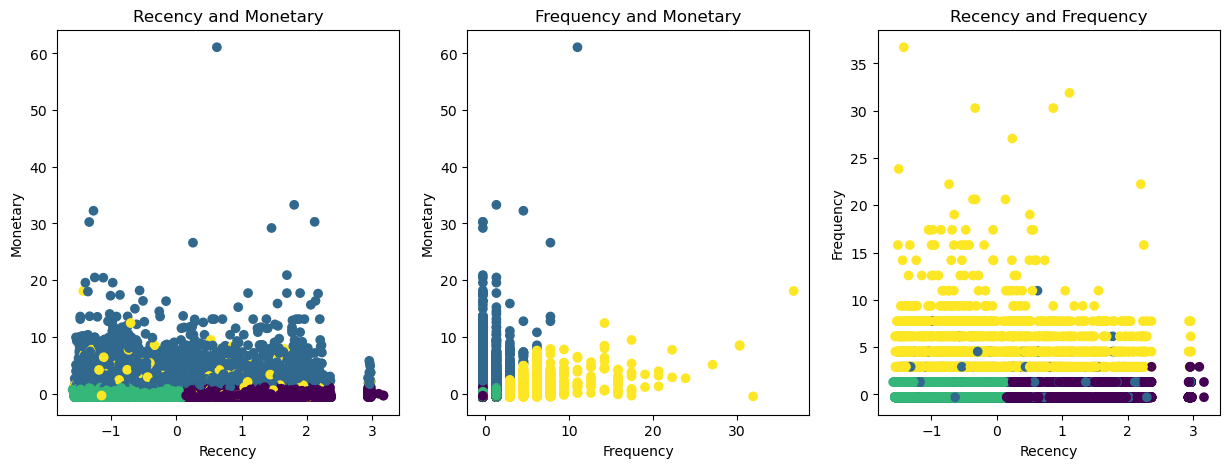

In [119]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
ax.scatter(X_std["Recency"], X_std["Monetary"], c=X_std["cluster"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('Recency and Monetary')

ax=plt.subplot(1,3,2)
ax.scatter(X_std["Frequency"], X_std["Monetary"], c=X_std["cluster"])
#ax.plot([-0.75, 1.25], [-1, -1], '--r')
#ax.plot([0.25, 0.25], [-1, 0.5], '--r')
ax.set_title('Frequency and Monetary')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax=plt.subplot(1,3,3)
ax.scatter(X_std["Recency"], X_std["Frequency"], c=X_std["cluster"])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_title('Recency and Frequency')

plt.show()

In [92]:
X_sample = X_std[['Recency', 'Monetary', 'Frequency']].sample(frac=0.1)

In [121]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_sample)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4)

In [122]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X_sample)

In [123]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

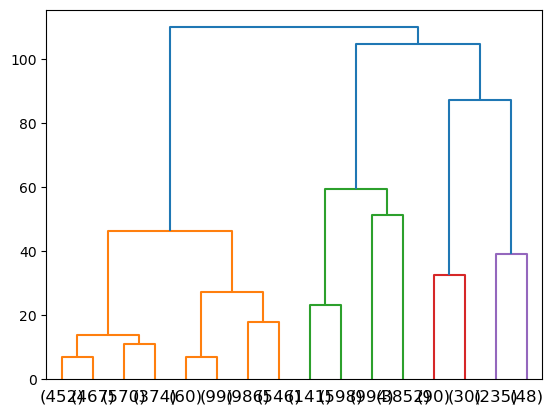

In [124]:
from scipy.cluster.hierarchy import dendrogram

plot_dendrogram(model, truncate_mode="level", p=3)

In [125]:
model = AgglomerativeClustering(distance_threshold=80, n_clusters=None)
model = model.fit(X_sample)

In [94]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=100).fit(X_sample)

In [93]:
db_eps10 = DBSCAN(eps=10, min_samples=100).fit(X_sample)
db_ms10 = DBSCAN(eps=1, min_samples=10).fit(X_sample)

In [127]:
X_sample["cluster_Kmeans"] = kmeans.labels_

In [128]:
X_sample["cluster_ACH"] = model.labels_

In [95]:
X_sample['cluster_DB'] = db.labels_

In [96]:
X_sample['cluster_DB_eps10'] = db_eps10.labels_
X_sample['cluster_DB_ms10'] = db_ms10.labels_

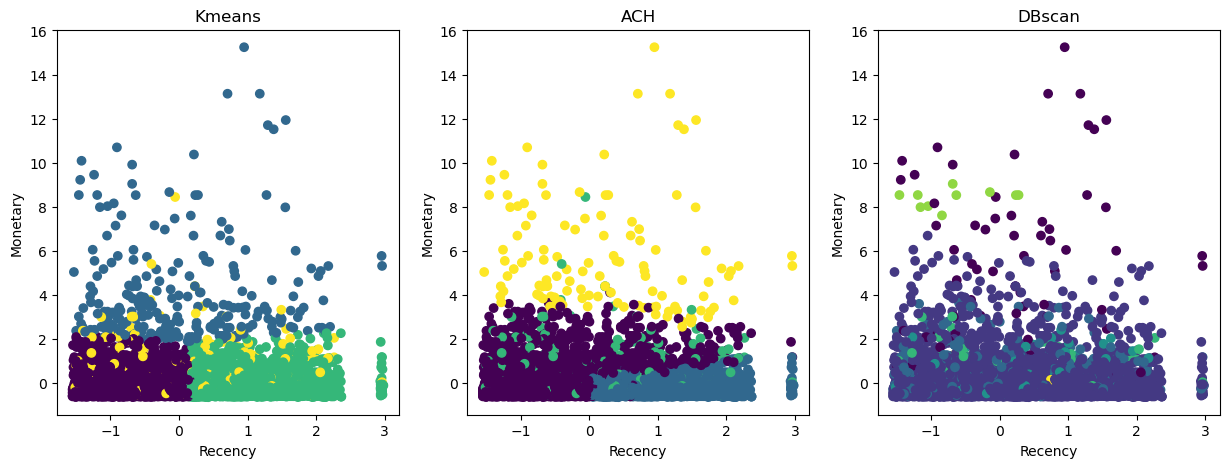

In [130]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
ax.scatter(X_sample["Recency"], X_sample["Monetary"], c=X_sample["cluster_Kmeans"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('Kmeans')

ax=plt.subplot(1,3,2)
ax.scatter(X_sample["Recency"], X_sample["Monetary"], c=X_sample["cluster_ACH"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('ACH')

ax=plt.subplot(1,3,3)
ax.scatter(X_sample["Recency"], X_sample["Monetary"], c=X_sample["cluster_DB"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('DBscan')

plt.show()

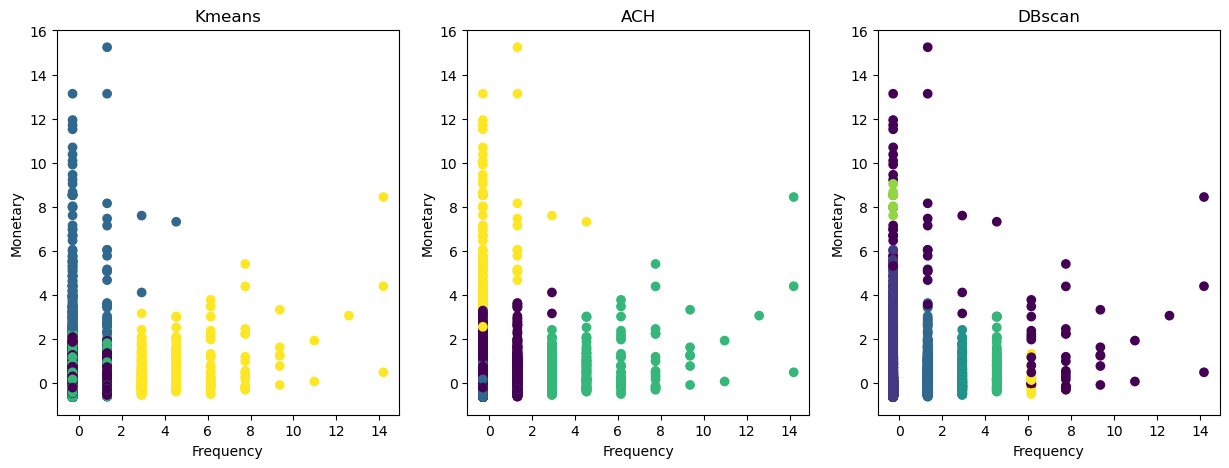

In [131]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
ax.scatter(X_sample["Frequency"], X_sample["Monetary"], c=X_sample["cluster_Kmeans"])
#ax.plot([-0.75, 1.25], [-1, -1], '--r')
#ax.plot([0.25, 0.25], [-1, 0.5], '--r')
ax.set_title('Kmeans')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax=plt.subplot(1,3,2)
ax.scatter(X_sample["Frequency"], X_sample["Monetary"], c=X_sample["cluster_ACH"])
#ax.plot([-0.75, 1.25], [-1, -1], '--r')
#ax.plot([0.25, 0.25], [-1, 0.5], '--r')
ax.set_title('ACH')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

ax=plt.subplot(1,3,3)
ax.scatter(X_sample["Frequency"], X_sample["Monetary"], c=X_sample["cluster_DB"])
#ax.plot([-0.75, 1.25], [-1, -1], '--r')
#ax.plot([0.25, 0.25], [-1, 0.5], '--r')
ax.set_title('DBscan')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')

plt.show()

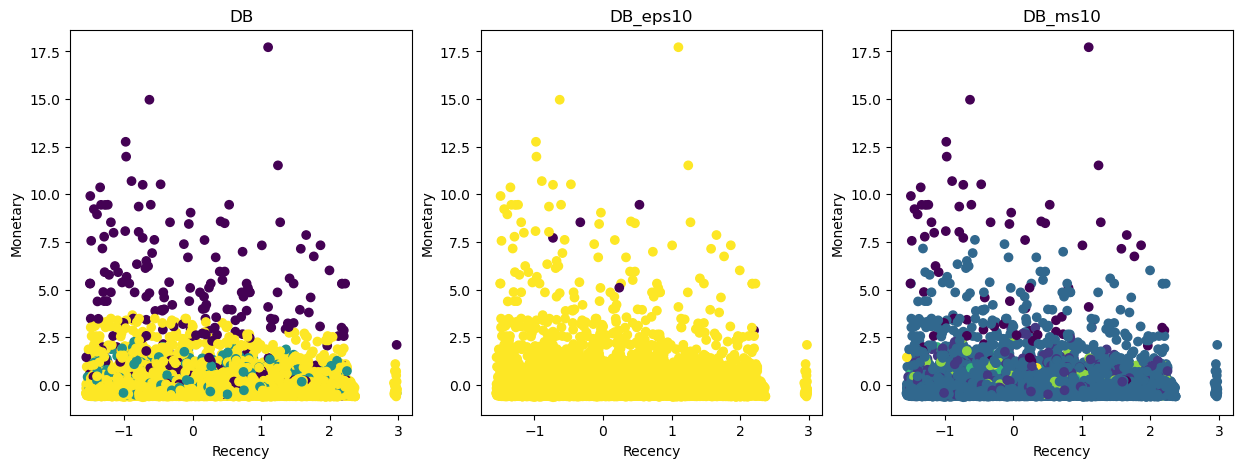

In [97]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,3,1)
ax.scatter(X_sample["Recency"], X_sample["Monetary"], c=X_sample["cluster_DB"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('DB')

ax=plt.subplot(1,3,2)
ax.scatter(X_sample["Recency"], X_sample["Monetary"], c=X_sample["cluster_DB_eps10"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('DB_eps10')

ax=plt.subplot(1,3,3)
ax.scatter(X_sample["Recency"], X_sample["Monetary"], c=X_sample["cluster_DB_ms10"])
#ax.plot([0, 800], [1400, 1400], '--r')
#ax.plot([0, 800], [500, 500], '--r')
#ax.plot([250, 250], [0, 500], 'r')
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('DB_ms10')

plt.show()

In [162]:
days_scale = 10
nb_limit = 40000
days_old = 180

In [196]:
days_offset_list = [0, 30, 60, 90, 180]

In [224]:
ARI_past_dict = {}
ARI_fut_dict = {}

In [217]:
def ARI_past(X_ARI, n_clusters, days_scale, days_old):
    ARI_list = []
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_ARI[['Recency', 'Monetary', 'Frequency']])
    X_ARI['cluster'] = kmeans.labels_

    for i in range(int(days_old/days_scale)):
        X_old = X_ARI.loc[X_ARI['Recency']>=X_ARI['Recency'].min()+days_scale*i]
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(X_old[['Recency', 'Monetary', 'Frequency']])
        X_ARI['cluster_'+str(i)] = kmeans.predict(X_ARI[['Recency', 'Monetary', 'Frequency']])
        ARI_list.append(adjusted_rand_score(X_ARI['cluster'], X_ARI['cluster_'+str(i)]))
    
    return ARI_list

In [223]:
def ARI_fut(X_ARI, n_clusters, days_scale, days_old):
    ARI_list = []
    
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_ARI.loc[X_ARI['Recency']>=X_ARI['Recency'].min()+days_old,['Recency', 'Monetary', 'Frequency']])
    X_ARI['cluster_old'] = kmeans.predict(X_ARI[['Recency', 'Monetary', 'Frequency']])

    for i in range(int(days_old/days_scale)):
        X_fut = X_ARI.loc[X_ARI['Recency']>X_ARI['Recency'].min()+days_old-days_scale*i]
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(X_fut[['Recency', 'Monetary', 'Frequency']])
        X_fut['cluster'] = kmeans.labels_
        ARI_list.append(adjusted_rand_score(X_fut['cluster_old'], X_fut['cluster']))

    return ARI_list

In [225]:
for d in days_offset_list:
    X_ARI = X.loc[X['Recency']>=d,['Recency', 'Monetary', 'Frequency']].copy()
    ARI_past_dict[str(d)+'j'] = ARI_past(X_ARI, 4, days_scale, days_old)
    ARI_fut_dict[str(d)+'j'] = ARI_fut(X_ARI, 4, days_scale, days_old)

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

In [ ]:
ARI_list = []
ARI_fut_list = []
X_ARI = X[['Recency', 'Monetary', 'Frequency']].copy()

In [163]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_ARI[['Recency', 'Monetary', 'Frequency']])
X_ARI['cluster'] = kmeans.labels_

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [167]:
from sklearn.metrics.cluster import adjusted_rand_score
for i in range(int(X_ARI.Recency.max()/days_scale)):
    X_old = X_ARI.loc[X_ARI['Recency']>days_scale*i]
    if(X_old.shape[0]>nb_limit):
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(X_old[['Recency', 'Monetary', 'Frequency']])
        X_ARI['cluster_'+str(i)] = kmeans.predict(X_ARI[['Recency', 'Monetary', 'Frequency']])
        ARI_list.append(adjusted_rand_score(X_ARI['cluster'], X_ARI['cluster_'+str(i)]))

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

In [175]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_ARI.loc[X_ARI['Recency']>days_old,['Recency', 'Monetary', 'Frequency']])
X_ARI['cluster_old'] = kmeans.predict(X_ARI[['Recency', 'Monetary', 'Frequency']])

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [177]:
for i in range(int(days_old/days_scale)):
    X_fut = X_ARI.loc[X_ARI['Recency']>days_old-days_scale*i]
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(X_fut[['Recency', 'Monetary', 'Frequency']])
    X_fut['cluster'] = kmeans.labels_
    ARI_fut_list.append(adjusted_rand_score(X_fut['cluster_old'], X_fut['cluster']))

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18008\3495321112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fut['cluster'] = kmeans.labels_
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18008\3495321112.py

In [188]:
ARI_list_3m = []
ARI_fut_list_3m = []
X_ARI_3m = X_ARI.loc[X_ARI['Recency']>90,['Recency', 'Monetary', 'Frequency']].copy()

In [189]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_ARI_3m[['Recency', 'Monetary', 'Frequency']])
X_ARI_3m['cluster'] = kmeans.labels_

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [190]:
from sklearn.metrics.cluster import adjusted_rand_score
for i in range(int(X_ARI_3m.Recency.max()/days_scale)):
    X_old = X_ARI_3m.loc[X_ARI_3m['Recency']>90+days_scale*i]
    if(X_old.shape[0]>nb_limit-10000):
        kmeans = KMeans(n_clusters=4)
        kmeans.fit(X_old[['Recency', 'Monetary', 'Frequency']])
        X_ARI_3m['cluster_'+str(i)] = kmeans.predict(X_ARI_3m[['Recency', 'Monetary', 'Frequency']])
        ARI_list_3m.append(adjusted_rand_score(X_ARI_3m['cluster'], X_ARI_3m['cluster_'+str(i)]))

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly

In [192]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_ARI_3m.loc[X_ARI_3m['Recency']>90+days_old,['Recency', 'Monetary', 'Frequency']])
X_ARI_3m['cluster_old'] = kmeans.predict(X_ARI_3m[['Recency', 'Monetary', 'Frequency']])

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [193]:
for i in range(int(days_old/days_scale)):
    X_fut = X_ARI_3m.loc[X_ARI_3m['Recency']>90+days_old-days_scale*i]
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(X_fut[['Recency', 'Monetary', 'Frequency']])
    X_fut['cluster'] = kmeans.labels_
    ARI_fut_list_3m.append(adjusted_rand_score(X_fut['cluster_old'], X_fut['cluster']))

D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18008\637080553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_fut['cluster'] = kmeans.labels_
D:\logiciels\Python\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_18008\637080553.py:5

In [222]:
ARI_fut_dict

{'0j': [], '30j': [], '60j': [], '90j': [], '180j': []}

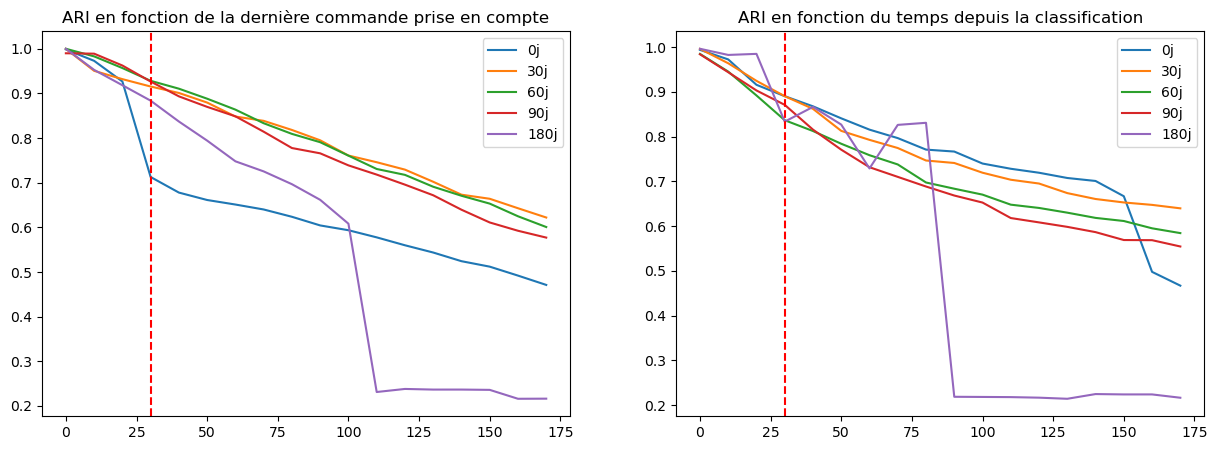

In [226]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
for string in list(ARI_past_dict.keys()):
    ax.plot(range(0, days_scale*len(ARI_past_dict[string]), days_scale), ARI_past_dict[string], label=string)
ax.axvline(30, linestyle='--', color='r')
ax.set_title('ARI en fonction de la dernière commande prise en compte')
ax.legend()

ax=plt.subplot(1,2,2)
for string in list(ARI_fut_dict.keys()):
    ax.plot(range(0, days_scale*len(ARI_fut_dict[string]), days_scale), ARI_fut_dict[string], label=string)
ax.axvline(30, linestyle='--', color='r')
ax.set_title('ARI en fonction du temps depuis la classification')
ax.legend()

plt.show()

In [136]:
data_final = customers_first_features.copy()

In [137]:
data_final['order_purchase_timestamp'] = pd.to_datetime(data_final['order_purchase_timestamp'])
data_final['Recency'] = (data_final['order_purchase_timestamp'].max() - data_final['order_purchase_timestamp']).dt.days
data_final.drop('order_purchase_timestamp', inplace=True, axis=1)

In [139]:
F_th = 1
M_th = 1000

In [140]:
R_th1 = 90
R_th2 = 180
R_th3 = 365
RS_th = 2

In [141]:
F_min = 0
F_max = data_final['nb'].max()
M_min = 0
M_max = data_final['Monetary'].max()

In [143]:
R_min = 0
R_max = data_final['Recency'].max()
RS_min = 0
RS_max = 5

In [144]:
data_final.loc[(data_final['nb']>F_th)&(data_final['Monetary']>M_th), 'cluster'] = 1
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']>M_th), 'cluster'] = 2
data_final.loc[(data_final['nb']>F_th)&(data_final['Monetary']<=M_th), 'cluster'] = 3
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)
    &(data_final['Recency']<=R_th1)&(data_final['review_score']>3), 'cluster'] = 4
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)
    &(data_final['Recency']>R_th1)&(data_final['Recency']<=R_th2)&(data_final['review_score']>RS_th), 'cluster'] = 5
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)
    &(data_final['Recency']<=R_th1)&(data_final['review_score']<=3)&(data_final['review_score']>0), 'cluster'] = 7
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)
    &(data_final['Recency']>R_th2)&(data_final['Recency']<=R_th3)&(data_final['review_score']>RS_th), 'cluster'] = 6
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)
    &(data_final['Recency']>R_th1)&(data_final['Recency']<=R_th3)&(data_final['review_score']<=RS_th), 'cluster'] = 8
data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)&(data_final['Recency']>R_th3), 'cluster'] = 9

Text(544.0, 0.1, '20393')

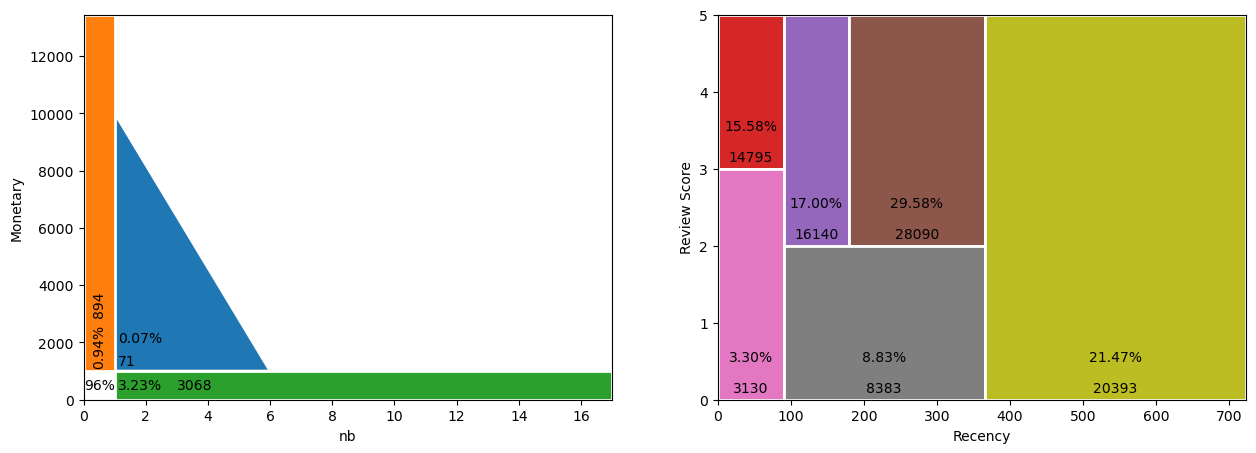

In [145]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.set_xlim([F_min, F_max])
ax.set_ylim([M_min, M_max])
ax.set_xlabel('nb')
ax.set_ylabel('Monetary')

r = Polygon([(F_th, M_th), (6, M_th), (F_th, 10000)], fc=colormaps['tab10'].colors[0], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(F_th+0.1, M_th+1000, f"{len(data_final.loc[data_final['cluster']==1])/len(data_final)*100:.2f}%")
ax.text(F_th+0.1, M_th+200, str(len(data_final.loc[data_final['cluster']==1])))

r = Rectangle((F_th, M_min), F_max-F_th, M_th, fc=colormaps['tab10'].colors[2], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(F_th+0.1, M_th/2, f"{len(data_final.loc[data_final['cluster']==3])/len(data_final)*100:.2f}%", va='center')
ax.text(F_th+2, M_th/2, str(len(data_final.loc[data_final['cluster']==3])), va='center')

r = Rectangle((F_min, M_th), F_th, M_max-M_th, fc=colormaps['tab10'].colors[1], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(F_th/2, M_th+200, f"{len(data_final.loc[data_final['cluster']==2])/len(data_final)*100:.2f}%", rotation=90, ha='center')
ax.text(F_th/2, M_th+2000, str(len(data_final.loc[data_final['cluster']==2])), rotation=90, ha='center')

ax.text(F_th/2, M_th/2, f"{len(data_final.loc[(data_final['nb']<=F_th)&(data_final['Monetary']<=M_th)])/len(data_final)*100:.0f}%",
        va='center', ha='center')


ax=plt.subplot(1,2,2)
ax.set_xlim([R_min, R_max])
ax.set_ylim([RS_min, RS_max])
ax.set_xlabel('Recency')
ax.set_ylabel('Review Score')

r = Rectangle((R_min, 3), R_th1, RS_max-3, fc=colormaps['tab10'].colors[3], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(R_th1/2, 3+0.5, f"{len(data_final.loc[data_final['cluster']==4])/len(data_final)*100:.2f}%", ha='center')
ax.text(R_th1/2, 3+0.1, str(len(data_final.loc[data_final['cluster']==4])), ha='center')

r = Rectangle((R_min, 0), R_th1, 3-0, fc=colormaps['tab10'].colors[6], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(R_th1/2, 0+0.5, f"{len(data_final.loc[data_final['cluster']==7])/len(data_final)*100:.2f}%", ha='center')
ax.text(R_th1/2, 0+0.1, str(len(data_final.loc[data_final['cluster']==7])), ha='center')

r = Rectangle((R_th1, RS_th), R_th2-R_th1, RS_max-RS_th, fc=colormaps['tab10'].colors[4], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(R_th1+(R_th2-R_th1)/2, RS_th+0.5, f"{len(data_final.loc[data_final['cluster']==5])/len(data_final)*100:.2f}%", ha='center')
ax.text(R_th1+(R_th2-R_th1)/2, RS_th+0.1, str(len(data_final.loc[data_final['cluster']==5])), ha='center')

r = Rectangle((R_th2, RS_th), R_th3-R_th2, RS_max-RS_th, fc=colormaps['tab10'].colors[5], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(R_th2+(R_th3-R_th2)/2, RS_th+0.5, f"{len(data_final.loc[data_final['cluster']==6])/len(data_final)*100:.2f}%", ha='center')
ax.text(R_th2+(R_th3-R_th2)/2, RS_th+0.1, str(len(data_final.loc[data_final['cluster']==6])), ha='center')

r = Rectangle((R_th1, RS_min), R_th3-R_th1, RS_th, fc=colormaps['tab10'].colors[7], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(R_th1+(R_th3-R_th1)/2, RS_min+0.5, f"{len(data_final.loc[data_final['cluster']==8])/len(data_final)*100:.2f}%", ha='center')
ax.text(R_th1+(R_th3-R_th1)/2, RS_min+0.1, str(len(data_final.loc[data_final['cluster']==8])), ha='center')

r = Rectangle((R_th3, RS_min), R_max-R_th3, RS_max-RS_min, fc=colormaps['tab10'].colors[8], edgecolor='w', lw=2)
ax.add_patch(r)
ax.text(R_th3+(R_max-R_th3)/2, RS_min+0.5, f"{len(data_final.loc[data_final['cluster']==9])/len(data_final)*100:.2f}%", ha='center')
ax.text(R_th3+(R_max-R_th3)/2, RS_min+0.1, str(len(data_final.loc[data_final['cluster']==9])), ha='center')

In [146]:
states_others = np.sort(data_final['customer_state'].unique())[
data_final['customer_state'].value_counts(normalize=True).sort_index() < 0.1]

In [147]:
data_final.loc[data_final['customer_state'].isin(states_others), 'customer_state'] = 'Other'

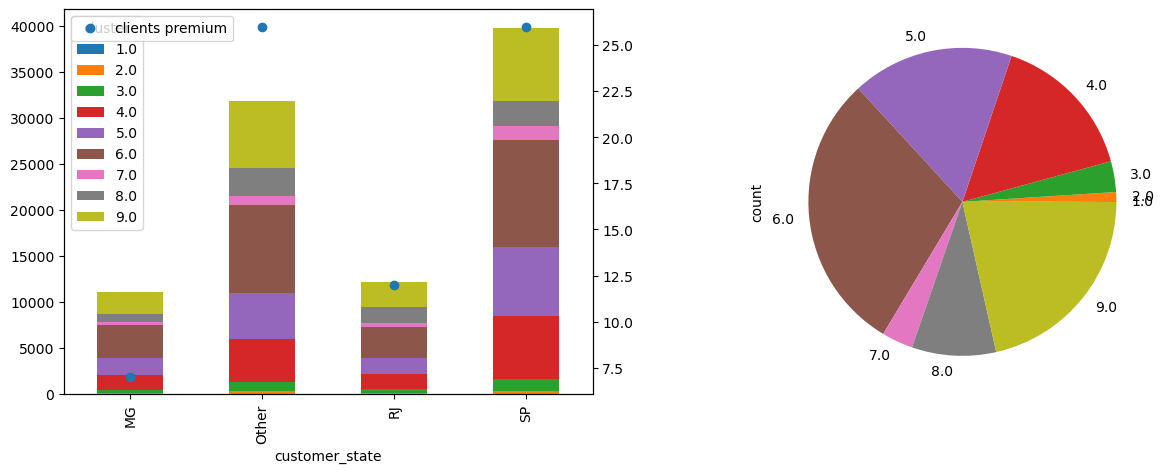

In [148]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
data_plot = pd.pivot_table(data_final, values='nb', aggfunc='count', index='customer_state', columns='cluster')
data_plot.plot.bar(ax=ax, stacked=True)
ax = ax.twinx()
data_final.loc[data_final['cluster']==1, 'customer_state'].value_counts().sort_index().plot(ax=ax, marker='o', ls='', label='clients premium')
ax.legend()

ax=plt.subplot(1,2,2)
data_final['cluster'].value_counts().sort_index().plot.pie(ax=ax)

plt.show()

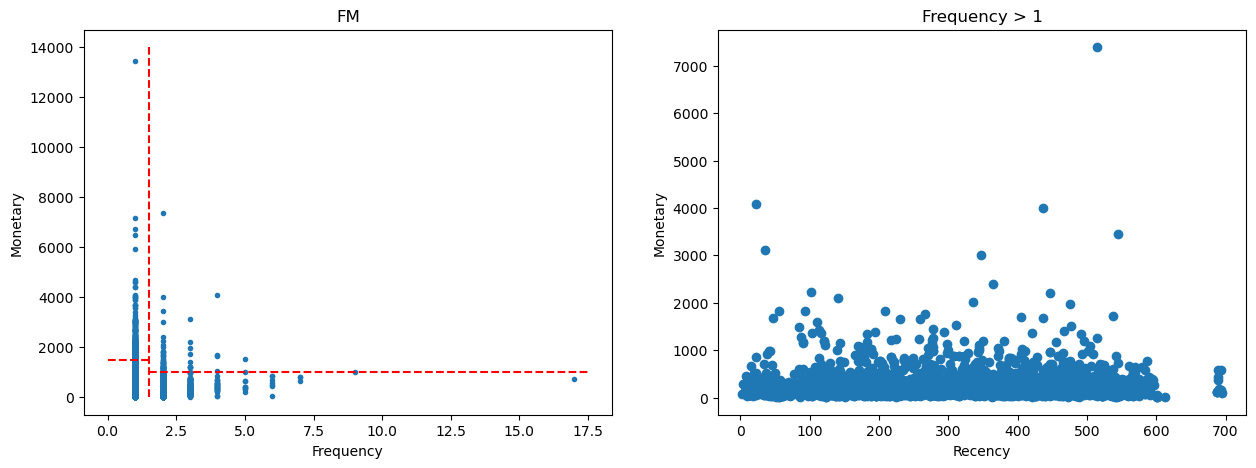

In [149]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.scatter(data_final['nb'], data_final['Monetary'], marker='.')
ax.plot([0, 1.5], [1500, 1500], '--r')
ax.plot([1.5, 17.5], [1000, 1000], '--r')
ax.plot([1.5, 1.5], [0, 14000], '--r')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_title('FM')

ax=plt.subplot(1,2,2)
data_plot = data_final.loc[(data_final['nb']>1)]
ax.scatter(data_plot['Recency'], data_plot['Monetary'])
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_title('Frequency > 1')

plt.show()

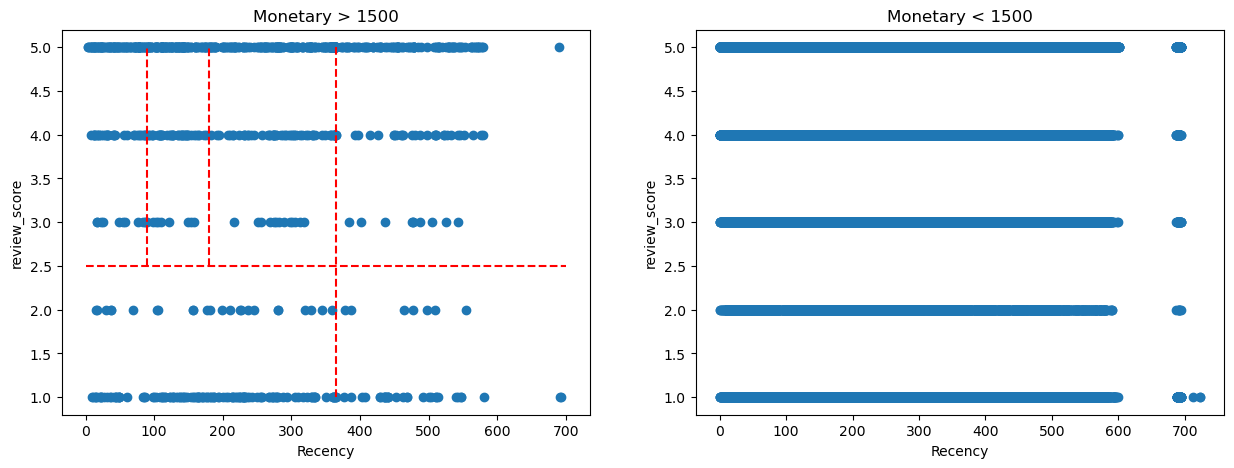

In [150]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
data_plot = data_final.loc[(data_final['nb']==1)&(data_final['Monetary']>1000)]
ax.scatter(data_plot['Recency'], data_plot['review_score'])
ax.plot([0, 700], [2.5, 2.5], '--r')
ax.plot([365, 365], [1, 5], '--r')
ax.plot([90, 90], [2.5, 5], '--r')
ax.plot([180, 180], [2.5, 5], '--r')
ax.set_xlabel('Recency')
ax.set_ylabel('review_score')
ax.set_title('Monetary > 1500')

ax=plt.subplot(1,2,2)
data_plot = data_final.loc[(data_final['nb']==1)&(data_final['Monetary']<1000)]
ax.scatter(data_plot['Recency'], data_plot['review_score'])
ax.set_xlabel('Recency')
ax.set_ylabel('review_score')
ax.set_title('Monetary < 1500')

plt.show()

<BarContainer object of 4 artists>

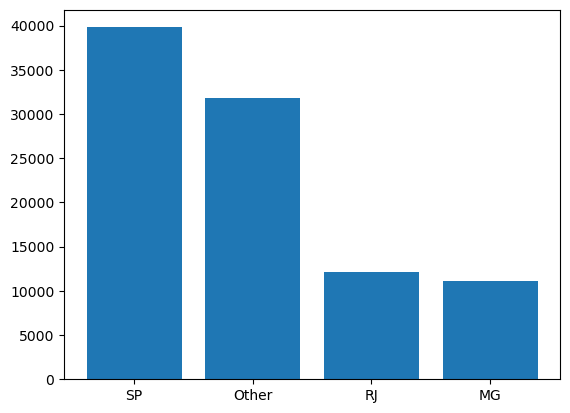

In [151]:
plt.bar(list(data_final['customer_state'].value_counts().index), data_final['customer_state'].value_counts())